# EDA

## Intro

In [1]:
%reload_ext autoreload
%autoreload 1
import joblib
import numpy as np
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
import auxiliary.lists as aux_lists
import auxiliary.transformers as tr
import auxiliary.eda_functions as eda
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from IPython.display import Markdown,display
import matplotlib.ticker as ticker
%aimport auxiliary.lists
%aimport auxiliary.transformers
%aimport auxiliary.eda_functions


In [2]:
sns.set()
BASE_FIG_SIZE=(8.5,4.5)

In [3]:
# applicattion_test=pl.read_csv('data/application_test.csv')
application_train=pl.read_csv('data/application_train.csv')
bureau_balance=pl.read_csv('data/bureau_balance.csv')
bureau=pl.read_csv('data/bureau.csv')
installments_payments=pl.read_csv('data/installments_payments.csv')
POS_CASH_balance=pl.read_csv('data/POS_CASH_balance.csv')
previous_application=pl.read_csv('data/previous_application.csv')
credit_card_balance=pl.read_csv('data/credit_card_balance.csv')
id_and_target=["SK_ID_CURR", "TARGET"]

## Data Integrity

#### Duplicates

In [4]:
application_train['SK_ID_CURR'].is_duplicated().any()

False

#### Missing Values


**Missing value graphical overview:**

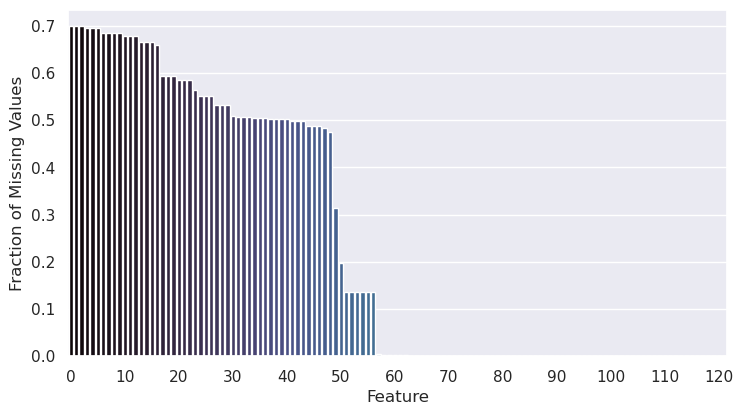

In [5]:
missing_values_main = pl.DataFrame(
    {
        "missing_fraction": application_train.null_count().transpose().to_series()
        / len(application_train),
        "feature": application_train.columns,
    }
).sort("missing_fraction", descending=True)

fig_main_missing, ax_main_missing = plt.subplots(figsize=BASE_FIG_SIZE)
sns.barplot(
    x=missing_values_main["feature"].to_numpy(),
    y=missing_values_main["missing_fraction"].to_numpy(),
    ax=ax_main_missing,
    palette=sns.color_palette('mako',n_colors=len(missing_values_main))
)
ax_main_missing.set_xticks(np.arange(len(missing_values_main), step=10))
ax_main_missing.set_xticklabels(np.arange(len(missing_values_main), step=10))
ax_main_missing.set_xlabel("Feature")
ax_main_missing.set_ylabel("Fraction of Missing Values")
plt.show()

**Features with most missing values:**

In [6]:
missing_values_main[:10]

missing_fraction,feature
f64,str
0.698723,"""COMMONAREA_AVG…"
0.698723,"""COMMONAREA_MOD…"
0.698723,"""COMMONAREA_MED…"
0.69433,"""NONLIVINGAPART…"
0.69433,"""NONLIVINGAPART…"
0.69433,"""NONLIVINGAPART…"
0.683862,"""FONDKAPREMONT_…"
0.68355,"""LIVINGAPARTMEN…"
0.68355,"""LIVINGAPARTMEN…"


#### References in other tables:

**Percentage of users with reference in other tables:**

In [7]:
tables_with_reference = {
    "Bureau": bureau,
    "Positive Cash Balance": POS_CASH_balance,
    "Credit Card Balance": credit_card_balance,
    "Previous Application": previous_application,
    "Installments Payments": installments_payments,
}

for name, table in tables_with_reference.items():
    frac_with_reference = len(
        application_train.filter(pl.col("SK_ID_CURR").is_in(table["SK_ID_CURR"]))
    ) / len(application_train)
    display(
        Markdown(
            f"{round(frac_with_reference*100)}% of users have reference in {name} table."
        )
    )

86% of users have reference in Bureau table.

94% of users have reference in Positive Cash Balance table.

28% of users have reference in Credit Card Balance table.

95% of users have reference in Previous Application table.

95% of users have reference in Installments Payments table.

**Number of references per user:**

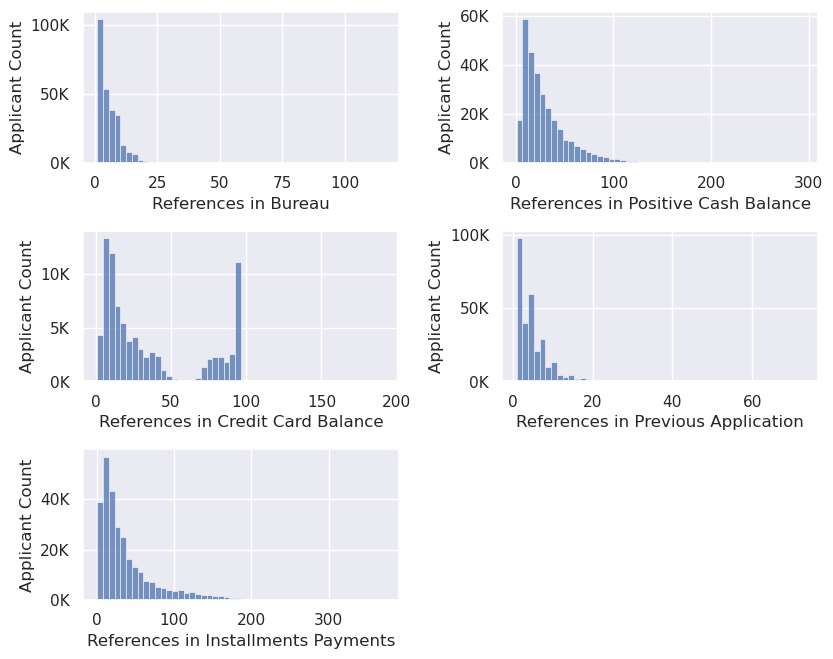

In [8]:
fig_reference_counts, ax_reference_counts = plt.subplots(
    3, 2, figsize=(BASE_FIG_SIZE[0], BASE_FIG_SIZE[1] * 1.5)
)
ax_reference_counts = ax_reference_counts.flatten()

for i, (name, table) in enumerate(tables_with_reference.items()):
    count_table = table.filter(
        pl.col("SK_ID_CURR").is_in(application_train["SK_ID_CURR"])
    )["SK_ID_CURR"].value_counts()

    sns.histplot(count_table["counts"], ax=ax_reference_counts[i],bins=50)
    # ax_reference_counts[i].set_title(name)
    ax_reference_counts[i].set_xlabel(f"References in {name}")
    ax_reference_counts[i].set_ylabel('Applicant Count')
    ax_reference_counts[i].yaxis.set_major_formatter(
        ticker.FuncFormatter(lambda x, pos: "{:,g}".format(x / 1000) + "K")
    )
plt.delaxes(ax_reference_counts[-1])
plt.tight_layout()
plt.show()

### Features generation

#### Bureau

**Numeric feature aggregations:**

In [9]:
bureau_agg = pl.DataFrame(application_train["SK_ID_CURR"])

bureau_num_cols = (
    bureau.select([pl.col(pl.FLOAT_DTYPES), pl.col(pl.INTEGER_DTYPES)])
    .drop(columns=id_and_target)
    .columns
)

for col in bureau_num_cols:
    bureau_agg = bureau_agg.join(
        bureau.group_by(pl.col("SK_ID_CURR")).agg(pl.col(col).mean().suffix("_mean")),
        on="SK_ID_CURR",
        how="left",
    )

for col in bureau_num_cols:
    bureau_agg = bureau_agg.join(
        bureau.group_by(pl.col("SK_ID_CURR")).agg(pl.col(col).sum().suffix("_sum")),
        on="SK_ID_CURR",
        how="left",
    )

for col in bureau_num_cols:
    bureau_agg = bureau_agg.join(
        bureau.group_by(pl.col("SK_ID_CURR")).agg(pl.col(col).min().suffix("_min")),
        on="SK_ID_CURR",
        how="left",
    )

for col in bureau_num_cols:
    bureau_agg = bureau_agg.join(
        bureau.group_by(pl.col("SK_ID_CURR")).agg(pl.col(col).max().suffix("_max")),
        on="SK_ID_CURR",
        how="left",
    )

for col in bureau_num_cols:
    bureau_agg = bureau_agg.join(
        bureau.group_by(pl.col("SK_ID_CURR")).agg(pl.col(col).std().suffix("_std")),
        on="SK_ID_CURR",
        how="left",
    )

**Aggregations from active credits only**

In [10]:
for col in bureau_num_cols:
    bureau_agg = bureau_agg.join(
        bureau.filter(pl.col("CREDIT_ACTIVE") == "Active")
        .group_by(pl.col("SK_ID_CURR"))
        .agg(pl.col(col).sum().suffix("_active_sum")),
        on="SK_ID_CURR",
        how="left",
    )

for col in bureau_num_cols:
    bureau_agg = bureau_agg.join(
        bureau.filter(pl.col("CREDIT_ACTIVE") == "Active")
        .group_by(pl.col("SK_ID_CURR"))
        .agg(pl.col(col).mean().suffix("_active_mean")),
        on="SK_ID_CURR",
        how="left",
    )

**Credit Counts:**

In [11]:
bureau_agg = bureau_agg.join(
    bureau.group_by(pl.col("SK_ID_CURR")).count(),
    on="SK_ID_CURR",
    how="left",
    suffix="_bureau_tot",
)

bureau_agg = bureau_agg.join(
    bureau.filter(pl.col("CREDIT_ACTIVE") == "Active")
    .group_by(pl.col("SK_ID_CURR"))
    .count(),
    on="SK_ID_CURR",
    how="left",
    suffix="_bureau_active",
)

bureau_agg = bureau_agg.join(
    bureau.filter(pl.col("CREDIT_ACTIVE") == "Closed")
    .group_by(pl.col("SK_ID_CURR"))
    .count(),
    on="SK_ID_CURR",
    how="left",
    suffix="_bureau_closed",
)

bureau_agg = bureau_agg.join(
    bureau.filter(pl.col("CREDIT_ACTIVE") == "Sold")
    .group_by(pl.col("SK_ID_CURR"))
    .count(),
    on="SK_ID_CURR",
    how="left",
    suffix="_bureau_sold",
)

**Credit Type**

In [12]:
bureau_agg = bureau_agg.join(
    bureau.group_by(pl.col("SK_ID_CURR"))
    .agg(pl.col("CREDIT_TYPE").mode().map_elements(lambda x: x[0])),
    on="SK_ID_CURR",
    how="left",
    suffix="_mode_tot",
)

bureau_agg = bureau_agg.join(
    bureau.filter(pl.col("CREDIT_ACTIVE") == "Active")
    .group_by(pl.col("SK_ID_CURR"))
    .agg(pl.col("CREDIT_TYPE").mode().map_elements(lambda x: x[0])),
    on="SK_ID_CURR",
    how="left",
    suffix="_mode_active",
)

In [13]:
bureau_balance['STATUS'].value_counts()

STATUS,counts
str,u32
"""5""",62406
"""4""",5847
"""0""",7499507
"""3""",8924
"""C""",13646993
"""1""",242347
"""2""",23419
"""X""",5810482


**Adding last balance status to bureau data:**

In [14]:
bureau=bureau.join(
    bureau_balance.group_by("SK_ID_BUREAU").agg(
        [pl.all().sort_by("MONTHS_BALANCE").last()]
    )[["SK_ID_BUREAU", "STATUS"]],
    on='SK_ID_BUREAU',
    how="left",
    suffix="_bureau_last",
)

**Adding days-past-due for each credit entry (last status) to bureau:**

In [20]:
bureau = bureau.with_columns(
    pl.col("STATUS").str.to_decimal().cast(pl.Int16).alias("DPD_approx")
)

In [25]:
bureau.head()

SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY,STATUS,DPD_aprox,DPD_approx
i64,i64,str,str,i64,i64,f64,f64,f64,i64,f64,f64,f64,f64,str,i64,str,str,i16,i16
215354,5714462,"""Closed""","""currency 1""",-497,0,-153.0,-153.0,null,0,91323.0,0.0,null,0.0,"""Consumer credi…",-131,null,null,null,null
215354,5714463,"""Active""","""currency 1""",-208,0,1075.0,null,null,0,225000.0,171342.0,null,0.0,"""Credit card""",-20,null,null,null,null
215354,5714464,"""Active""","""currency 1""",-203,0,528.0,null,null,0,464323.5,null,null,0.0,"""Consumer credi…",-16,null,null,null,null
215354,5714465,"""Active""","""currency 1""",-203,0,null,null,null,0,90000.0,null,null,0.0,"""Credit card""",-16,null,null,null,null
215354,5714466,"""Active""","""currency 1""",-629,0,1197.0,null,77674.5,0,2.7e6,null,null,0.0,"""Consumer credi…",-21,null,null,null,null


**Adding the data to the aggregated table**

In [26]:
bureau_agg = bureau_agg.join(
    bureau.group_by(pl.col("SK_ID_CURR")).agg(
        pl.col("STATUS").mode().map_elements(lambda x: x[0])
    ),
    on="SK_ID_CURR",
    how="left",
    suffix="_mode_tot",
)

bureau_agg = bureau_agg.join(
    bureau.filter(pl.col("CREDIT_ACTIVE") == "Active")
    .group_by(pl.col("SK_ID_CURR"))
    .agg(pl.col("STATUS").mode().map_elements(lambda x: x[0])),
    on="SK_ID_CURR",
    how="left",
    suffix="_mode_active",
)


bureau_agg = bureau_agg.join(
    bureau.group_by(pl.col("SK_ID_CURR")).agg(pl.col("DPD_approx").sum()),
    on="SK_ID_CURR",
    how="left",
    suffix="_sum_tot",
)


bureau_agg = bureau_agg.join(
    bureau.filter(pl.col("CREDIT_ACTIVE") == "Active")
    .group_by(pl.col("SK_ID_CURR"))
    .agg(pl.col("DPD_approx").sum()),
    on="SK_ID_CURR",
    how="left",
    suffix="_sum_active",
)

**Adding the bureau features to the application table:**

In [28]:
application_train=application_train.join(bureau_agg,on='SK_ID_CURR',how='left')

In [33]:
test_bureu_aggs = eda.test_with_catboost_crossval(
    application_train.drop(columns=id_and_target),
    application_train["TARGET"],
    sample_size=10000,
    cat_features=application_train.select(pl.col(pl.Utf8)).columns,
)

In [3]:
application_train, application_val = train_test_split(
    application_train,
    train_size=0.33,
    stratify=application_train["TARGET"],
    random_state=1,
)

In [4]:
application_train['TARGET'].value_counts()

TARGET,counts
i64,u32
1,8192
0,93286


In [7]:
string_cols=application_train.select(pl.col(pl.Utf8)).columns

### Feature importance

In [21]:
initial_test=eda.test_with_catboost(application_train,application_val,string_cols)
print(initial_test['report'])
print(initial_test['roc_auc'])
display(initial_test['features'][:10])

              precision    recall  f1-score   support

           0       0.96      0.73      0.83    189400
           1       0.17      0.64      0.27     16633

    accuracy                           0.72    206033
   macro avg       0.57      0.69      0.55    206033
weighted avg       0.90      0.72      0.78    206033



feature,importance
str,f64
"""EXT_SOURCE_3""",12.654869
"""EXT_SOURCE_2""",9.24611
"""EXT_SOURCE_1""",5.942974
"""AMT_CREDIT""",5.273107
"""AMT_GOODS_PRIC…",5.002266
"""AMT_ANNUITY""",4.473649
"""DAYS_BIRTH""",4.395158
"""DAYS_EMPLOYED""",3.758365
"""DAYS_ID_PUBLIS…",2.751794


### Common Sense Removal

In [9]:
application_edited_train = application_train.clone()
application_edited_val = application_val.clone()
cols_to_remove=[]

#### Home Feature Elimination

In [10]:
home_base_features = list(set([col.rsplit("_", 1)[0] for col in aux_lists.home_cols]))
best_home_features = []

for feature in home_base_features:
    best_home_features.append(
        initial_test["features"]
        .filter(pl.col("feature").str.starts_with(feature))
        .sort("importance")["feature"][0]
    )

cols_to_remove.extend([col for col in aux_lists.home_cols if col not in best_home_features])

### Col cats

In [11]:
application_train.filter(pl.col('FLAG_OWN_CAR')=="Y")['OWN_CAR_AGE'].null_count()

3

In [12]:
cols_to_remove.append('FLAG_OWN_CAR')

In [13]:
application_edited_train = application_edited_train.drop(cols_to_remove)

application_edited_val = application_edited_val.drop(cols_to_remove)

string_cols_reduced = application_edited_train.select(pl.col(pl.Utf8)).columns

test_home_removal = eda.test_with_catboost(
    application_edited_train, application_edited_val, string_cols_reduced
)

print(test_home_removal["report"])

              precision    recall  f1-score   support

           0       0.96      0.73      0.83    189400
           1       0.17      0.65      0.27     16633

    accuracy                           0.72    206033
   macro avg       0.57      0.69      0.55    206033
weighted avg       0.90      0.72      0.79    206033



### Variance

In [14]:
home_target_encoders = {}
application_edited_encoded=application_edited_train.clone()
for col in string_cols_reduced:
    home_target_encoders[col] = tr.TargetMeanOrderedLabeler(how="label")
    application_edited_encoded = application_edited_encoded.with_columns(
        home_target_encoders[col]
        .fit_transform(
            application_edited_encoded[col], application_edited_encoded["TARGET"]
        )
        .alias(col)
    )

In [15]:
feature_variance = pl.DataFrame(
    {
        "feature": application_edited_encoded.columns,
        "variance": np.var(MinMaxScaler().fit_transform(application_edited_encoded),axis=0),
    }
)
feature_variance.sort('variance')[:20]

feature,variance
str,f64
"""FLAG_MOBIL""",0.00001
"""FLAG_DOCUMENT_…",0.00001
"""FLAG_DOCUMENT_…",0.00001
"""FLAG_DOCUMENT_…",0.000039
"""FLAG_DOCUMENT_…",0.000108
"""FLAG_DOCUMENT_…",0.000177
"""AMT_INCOME_TOT…",0.00022
"""FLAG_DOCUMENT_…",0.000276
"""FLAG_DOCUMENT_…",0.000384


In [16]:
low_var_fatures=[]
for feature in feature_variance.filter(pl.col('variance')<0.001)['feature']:
    if application_edited_train[feature].n_unique()<10:
        low_var_fatures.append(feature)
        minority_count=application_edited_train[feature].value_counts().sort('counts')['counts'][0]
        print(f'{feature}: minority class count = {minority_count} feature will be removed')

FLAG_MOBIL: minority class count = 1 feature will be removed
FLAG_DOCUMENT_2: minority class count = 4 feature will be removed
FLAG_DOCUMENT_4: minority class count = 11 feature will be removed
FLAG_DOCUMENT_7: minority class count = 18 feature will be removed
FLAG_DOCUMENT_10: minority class count = 1 feature will be removed
FLAG_DOCUMENT_12: minority class count = 1 feature will be removed
FLAG_DOCUMENT_17: minority class count = 28 feature will be removed
FLAG_DOCUMENT_19: minority class count = 62 feature will be removed
FLAG_DOCUMENT_20: minority class count = 52 feature will be removed
FLAG_DOCUMENT_21: minority class count = 39 feature will be removed


In [17]:
application_edited_train=application_edited_train.drop(columns=low_var_fatures)
application_edited_val=application_edited_val.drop(columns=low_var_fatures)

In [23]:
test_var_removal = eda.test_with_catboost(
    application_edited_train, application_edited_val, string_cols_reduced
)

print(test_var_removal["report"])
print(test_var_removal["roc_auc"])

              precision    recall  f1-score   support

           0       0.96      0.73      0.83    189400
           1       0.17      0.64      0.27     16633

    accuracy                           0.72    206033
   macro avg       0.57      0.69      0.55    206033
weighted avg       0.90      0.72      0.78    206033



0.755768296203315
